Training complete!


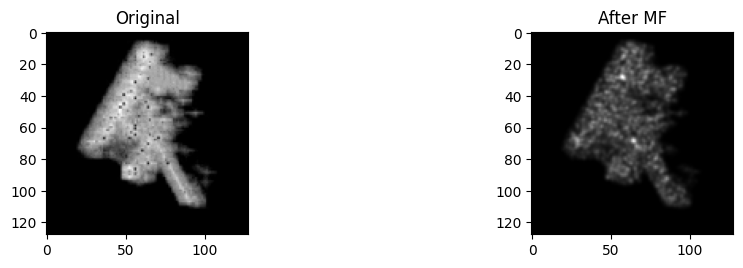

In [ ]:
!pip install torch torchvision matplotlib scikit-image

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
from scipy.signal import convolve2d

# ---- Step 1: Load SAR Image ----
img = io.imread("/content/Screenshot 2025-09-09 132120.png", as_gray=True)
img = cv2.resize(img, (128,128))
img = img / 255.0

# Add synthetic speckle noise
noise = np.random.gamma(shape=1.0, scale=1.0, size=img.shape)
speckled = img * noise / np.mean(noise)

# ---- Step 2: Apply Matched Filter (MF) ----
# Using a Gaussian kernel as the matched filter
mf_kernel = cv2.getGaussianKernel(ksize=7, sigma=1)
mf_kernel = mf_kernel @ mf_kernel.T
mf_result = convolve2d(speckled, mf_kernel, mode='same', boundary='symm')

# ---- Step 3: Define CNN (DnCNN style) ----
class DnCNN(nn.Module):
    def __init__(self, depth=6, n_channels=64):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(1, n_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(n_channels, 1, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # residual learning

# ---- Step 4: Train CNN on MF output ----
input_tensor = torch.tensor(mf_result, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
target_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

model = DnCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(200):
    output = model(input_tensor)
    loss = criterion(output, target_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Training complete!")

# ---- Step 5: Results ----
enhanced = output.detach().squeeze().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,4,3); plt.imshow(mf_result, cmap='gray'); plt.title("After MF")
plt.show()



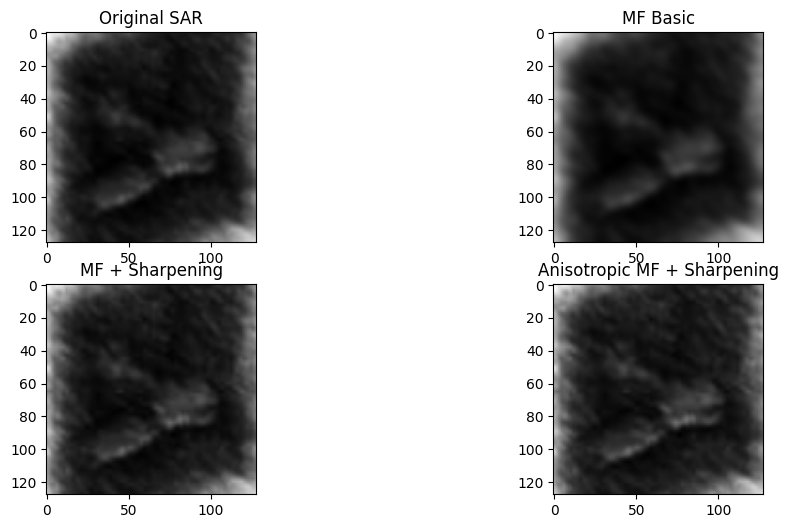

In [ ]:
# ---- Step 1: Load SAR Image ----
img = io.imread("/content/Screenshot 2025-09-09 123504.png", as_gray=True)
img = cv2.resize(img, (128,128))
img = img / 255.0

# ---- Step 2: Custom Matched Filter Function ----
def matched_filter_enhance(image, ksize=7, sigma=2, anisotropic=False, sharpen=True, alpha=0.5):
    """
    Apply matched filtering with optional anisotropy and sharpening.

    Params:
        image : input SAR image
        ksize : kernel size
        sigma : Gaussian sigma
        anisotropic : if True, use elliptical (anisotropic) Gaussian
        sharpen : if True, apply unsharp masking
        alpha : sharpening strength

    Returns:
        filtered image
    """
    if anisotropic:
        # Different sigmas in x and y -> elliptical kernel
        x = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
        y = cv2.getGaussianKernel(ksize=ksize, sigma=sigma/2)  # narrower in y
        kernel = x @ y.T
    else:
        # Normal isotropic Gaussian
        g = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
        kernel = g @ g.T

    # Convolution
    mf_result = convolve2d(image, kernel, mode='same', boundary='symm')

    if sharpen:
        # Unsharp masking for edge clarity
        enhanced = image + alpha * (image - mf_result)
        return np.clip(enhanced, 0, 1)
    else:
        return np.clip(mf_result, 0, 1)

# ---- Step 3: Apply Different Variants ----
mf_basic = matched_filter_enhance(img, ksize=7, sigma=2, anisotropic=False, sharpen=False)
mf_sharp = matched_filter_enhance(img, ksize=7, sigma=2, anisotropic=False, sharpen=True, alpha=0.7)
mf_aniso = matched_filter_enhance(img, ksize=15, sigma=3, anisotropic=True, sharpen=True, alpha=0.7)

# ---- Step 4: Show Results ----
plt.figure(figsize=(12,6))
plt.subplot(2,2,1); plt.imshow(img, cmap='gray'); plt.title("Original SAR")
plt.subplot(2,2,2); plt.imshow(mf_basic, cmap='gray'); plt.title("MF Basic")
plt.subplot(2,2,3); plt.imshow(mf_sharp, cmap='gray'); plt.title("MF + Sharpening")
plt.subplot(2,2,4); plt.imshow(mf_aniso, cmap='gray'); plt.title("Anisotropic MF + Sharpening")
plt.show()

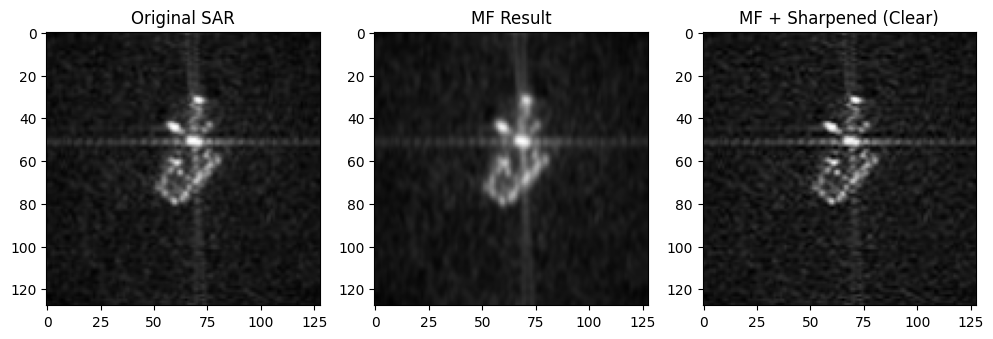

In [ ]:
img = io.imread("/content/Screenshot 2025-09-09 134713.png", as_gray=True)
img = cv2.resize(img, (128,128))
img = img / 255.0

# ---- Step 2: Enhanced Matched Filter Function ----
def matched_filter_clear(image, ksize=9, sigma=1.5, alpha=1.0):
    """
    Tuned Matched Filter for clearer SAR images.
    Uses anisotropic Gaussian + strong sharpening.
    """
    # Anisotropic kernel (different spreads in x, y)
    x = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
    y = cv2.getGaussianKernel(ksize=ksize, sigma=sigma/3)  # narrower in y
    kernel = x @ y.T

    # Convolution
    mf_result = convolve2d(image, kernel, mode='same', boundary='symm')

    # Strong unsharp masking (edge enhancement)
    enhanced = image + alpha * (image - mf_result)

    return np.clip(enhanced, 0, 1), mf_result

# ---- Step 3: Apply Filter ----
mf_enhanced, mf_result = matched_filter_clear(img)

# ---- Step 4: Show Results ----
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original SAR")
plt.subplot(1,3,2); plt.imshow(mf_result, cmap='gray'); plt.title("MF Result")
plt.subplot(1,3,3); plt.imshow(mf_enhanced, cmap='gray'); plt.title("MF + Sharpened (Clear)")
plt.show()

# SAR Image Denoising and Enhancement: A Hybrid Approach

## 1. Introduction: The Challenge of SAR Imagery

*   Synthetic Aperture Radar (SAR) provides critical all-weather, day-night imaging capabilities.
*   **Challenge:** SAR images are inherently affected by **speckle noise**, a granular noise that degrades image quality, obscures details, and complicates analysis.
*   **Impact on Army Operations:** Speckle noise reduces the effectiveness of:
    *   Target detection and recognition
    *   Terrain analysis and navigation
    *   Change detection and damage assessment
    *   Automated image processing and intelligence gathering

## 2. Our Denoising Pipeline: A Hybrid Solution

This program implements a robust, two-stage pipeline combining traditional signal processing with deep learning for superior speckle noise reduction and image enhancement.

### Stage 1: Initial Denoising with Matched Filter (MF)

*   **Purpose:** To provide an initial smoothing effect, reduce prominent noise, and enhance features relevant to the image content.
*   **Mechanism:** Convolves the noisy SAR image with a specialized kernel (often a Gaussian) designed to maximize signal-to-noise ratio for expected features.
*   **Variants Explored:**
    *   **Basic MF:** Standard isotropic smoothing.
    *   **Anisotropic MF:** Uses an elliptical kernel (different spreads in x and y) to better preserve directional features like roads or edges.
    *   **Sharpening (Unsharp Masking):** Applied post-filtering to accentuate edges and details, improving visual clarity.



**Insight 1:** Initial MF effectively reduces overall noise but can blur fine details. Anisotropic MF and sharpening begin to address this.

### Stage 2: Deep Learning Refinement with DnCNN

*   **Purpose:** To further remove residual noise after MF and recover finer image details that traditional filters might smooth out or miss.
*   **Model:** A Deep Convolutional Neural Network (DnCNN) architecture, known for its effectiveness in image denoising.
*   **Mechanism (Residual Learning):** Instead of directly predicting the clean image, the DnCNN learns to predict the *noise component* present in the MF output. The clean image is then reconstructed by subtracting this predicted noise.
    *   This approach is highly efficient for learning complex noise patterns.
*   **Training:** The network is trained using the MF output as input and the original clean SAR image as the ground truth target, minimizing the difference between the network's output (clean image) and the true clean image.



**Insight 2:** The DnCNN significantly improves upon the MF output, revealing more subtle structures and further reducing noise while preserving edges.

## 3. Program Results & Visual Impact

The hybrid pipeline demonstrates a significant improvement in SAR image quality, leading to clearer and more interpretable data.



**Insight 3:** The combination of MF and DnCNN yields a substantially cleaner image, enabling better visual analysis and downstream automated processing.

## 4. Key Advantages for Army Applications

This denoising program offers several critical advantages for military and intelligence operations:

*   **Enhanced Situational Awareness:** Provides clearer, more discernible imagery for real-time and post-mission analysis, allowing for quicker and more accurate identification of targets, infrastructure, and terrain features.
*   **Improved Intelligence Gathering:** Denoised SAR data leads to higher confidence in intelligence reports, reducing ambiguity and improving decision-making processes.
*   **Robustness in Challenging Environments:** SAR's ability to penetrate clouds and operate at night is amplified by robust denoising, ensuring reliable intelligence even in adverse weather or obscured conditions.
*   **Optimized Automated Analysis:** Cleaner images serve as superior input for AI/ML-driven object detection, segmentation, and change detection algorithms, leading to higher accuracy and reduced false positives.
*   **Efficient Resource Utilization:** Maximizes the utility and interpretability of data collected from expensive SAR platforms, providing more actionable intelligence from each mission.
*   **Reduced Operator Fatigue:** Clearer images require less mental effort and time for manual interpretation, improving efficiency and reducing error rates for image analysts.

## 5. Conclusion & Future Directions

This hybrid SAR image denoising pipeline represents a significant step towards improving the utility of SAR data for critical army applications. Further work could include testing on diverse real-world SAR datasets, integration with larger image processing workflows, and exploration of more advanced deep learning architectures for specific operational requirements.